# Lecture des métadonnées d'un nuage de points

Pour débuter, nous allons charger un fichier las/laz.


In [2]:
%%time
import subprocess
import json
from shapely.geometry import Polygon
from pathlib import Path


#chemin du fichier source
datasource = Path(r'C:\Users\prazm\Documents\brevet_pointcloud_python\data\input')
file = 'test.laz'

#exécution de pdal info pour accéder aux métadonnées du fichier 
result = subprocess.run(['pdal', 'info', datasource/file],
                        stderr = subprocess.PIPE,  # stderr and stdout get
                        stdout = subprocess.PIPE)  # captured as bytestrings

# décode du stdout en bytestring et parsage dans un dictionnaire
json_result = json.loads(result.stdout.decode())


CPU times: total: 0 ns
Wall time: 6.68 s


Les métadonnées du fichier sont maintenant contenues dans un dictionnaire

In [3]:
print (json_result)

{'file_size': 59893484, 'filename': 'C:\\Users\\prazm\\Documents\\brevet_pointcloud_python\\data\\input\\test.laz', 'now': '2022-08-04T08:10:32+0200', 'pdal_version': '2.4.2 (git-version: Release)', 'reader': 'readers.las', 'stats': {'bbox': {'native': {'bbox': {'maxx': 2560957.34, 'maxy': 1145889.72, 'maxz': 1152.7, 'minx': 2560075.67, 'miny': 1145137.73, 'minz': 795.86}, 'boundary': {'type': 'Polygon', 'coordinates': [[[2560075.67, 1145137.73, 795.86], [2560075.67, 1145889.72, 795.86], [2560957.34, 1145889.72, 1152.7], [2560957.34, 1145137.73, 1152.7], [2560075.67, 1145137.73, 795.86]]]}}}, 'statistic': [{'average': 2560567.03, 'count': 10731448, 'maximum': 2560957.34, 'minimum': 2560075.67, 'name': 'X', 'position': 0, 'stddev': 197.4748674, 'variance': 38996.32324}, {'average': 1145498.52, 'count': 10731448, 'maximum': 1145889.72, 'minimum': 1145137.73, 'name': 'Y', 'position': 1, 'stddev': 199.5701792, 'variance': 39828.25643}, {'average': 968.0563265, 'count': 10731448, 'maximum':

# Création d'un poylgon selon l'emprise boundary

Grace aux métadonnées et plus spécifiquement à l'attribut **boundary**, nous récupérons l'emprise du nuage de points

In [4]:
coords = json_result['stats']['bbox']['native']['boundary']['coordinates']
print (coords)
bbox_poly = Polygon(*coords)

[[[2560075.67, 1145137.73, 795.86], [2560075.67, 1145889.72, 795.86], [2560957.34, 1145889.72, 1152.7], [2560957.34, 1145137.73, 1152.7], [2560075.67, 1145137.73, 795.86]]]


Nous remarquons que les coordonnées dépendent du sysème de projection du fichier (en l'occurence Swiss CH1903+ / LV95).

Nous souhaitons visualiser l'emprise avec **ipyleaflet** (une intégration de LeafletJS à Jupyter). Nous devons donc **reprojeter** l'emprise de ch1903plus vers le crs par défaut d'ipyleflet (WGS84).

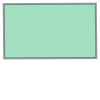

POLYGON Z ((6.918974882598839 46.45637759721659 795.86, 6.918909879591284 46.463142062180104 795.86, 6.930387099755627 46.46319422406698 1152.7, 6.930450669978589 46.456429752607086 1152.7, 6.918974882598839 46.45637759721659 795.86))


Map(center=[46.45978597939353, 6.92468063231009], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [5]:
import pyproj
import IPython.display
import ipyleaflet
from ipyleaflet import Map, WKTLayer
from shapely.ops import transform
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
project  = pyproj.Transformer.from_crs(ch1903plus, wsg84, always_xy=True).transform
wsg84_bbox_poly=transform(project, bbox_poly)
IPython.display.display(wsg84_bbox_poly)
print(wsg84_bbox_poly.wkt)
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=14)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
m

Nous voyons donc ci-dessus l'emrpise du nuage de points. De manière plus précise, c'est l'emprise rectangulaire définie par les coordonnées minimales et maximales des points.

# Extraction des points

Nous souhaitons traiter une zone en particulier. Je vous propose de saisir cette zone via l'outil **Draw a polygon** un polygone de la zone à extraire.

In [6]:
from pyproj import Transformer
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=16)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

Map(center=[46.45978597939353, 6.92468063231009], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

Une fois le polygone tracé avec l'outil polygone, exécuter la cellule suivante.

POLYGON ((2560346.377604345 1145513.638549204, 2560768.9669661047 1145545.7726707803, 2560764.5502249757 1145504.669476456, 2560468.92921883 1145352.6388801646, 2560346.377604345 1145513.638549204))


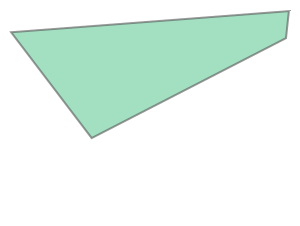

In [7]:
from pyproj import transformer
import shapely
transformer = Transformer.from_crs(wsg84, ch1903plus)
coords_draw = [transformer.transform(y,x) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon_draw = shapely.geometry.Polygon(coords_draw)
print(polygon_draw.wkt)
IPython.display.display(polygon_draw)

Ci-dessus, le polygone que nous avons dessiné.

In [8]:
print(polygon_draw.bounds)

(2560346.377604345, 1145352.6388801646, 2560768.9669661047, 1145545.7726707803)


Via PDAL, nous allons **filtrer** les points du nuage d'origine en fonction du poylgone que nous venons de déterminer.

In [9]:
import pdal
polygon_draw_bounds = polygon_draw.bounds
cropper = {
    "pipeline": [str(datasource/file),
        {   "type":"filters.crop",
            'bounds':str(([polygon_draw_bounds[0], polygon_draw_bounds[2]],[polygon_draw_bounds[1], polygon_draw_bounds[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon_draw.wkt},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
#pipeline.validate()
%time n_points = pipeline.execute()

print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon_draw.area))

CPU times: total: 21.1 s
Wall time: 21.9 s
Pipeline selected 797819 points (19.1 pts/m2)


# Visualisation

Nous allons visualiser les points extraits via **Ipyvolume**.

In [10]:
import ipyvolume.pylab as p3
import pandas as pd
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [12]:
fig = p3.figure(width=600)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

Travaille du rendu pour que ce soit plus compréhensible. On crée une surface avec les points "groud" puis ces points sont supprimés.

In [13]:
import scipy
# Color ground in grey
df['ground'] = df['Classification']==2
ground = p3.scatter(df.loc[df['ground'],'Y'].values, df.loc[df['ground'],'Z'].values, df.loc[df['ground'],'X'].values, color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'].values, df.loc[~df['ground'],'Z'].values, df.loc[~df['ground'],'X'].values, color='red', size=.2)
fig.scatters.append(ground)
#fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

# Enregistrement

